# Image Mapping

This code produces the mappings shown in parts 10-13 of the [Imaginary Numbers Are Real](https://youtu.be/pNp8Qf20-sA) YouTube Series. 

To run this code you'll need [opencv](http://opencv.org/), and I recommend [Anaconda Python](https://docs.continuum.io/anaconda/).

@stephencwelch

Populating the interactive namespace from numpy and matplotlib


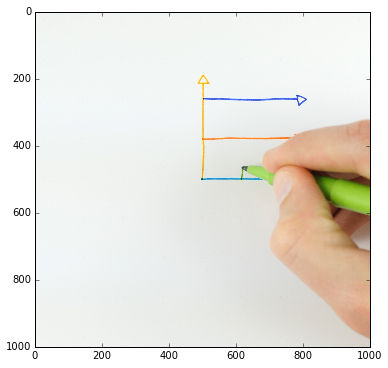

In [14]:
%pylab inline
import time

#Import an image to map:
import matplotlib.image as mpimg
img = mpimg.imread("graphics/imageToMap.jpg")

figure(0, (6,6))
imshow(img)

## How can we map the pixels in our image according for our function $f(z) = z^2$?

## First, let's assign every pixel in the image to complex number. 

- To do this, we'll need to pick maximum and minimum complex numbers for the edges of our image.
- Somethning I learned early on, is that for this function, we need to map our image one half at a time. 

In [15]:
imgRight = img[:,img.shape[1]/2:]
inputBounds = np.array([0, 2, -2, 2])
inputResolution = imgRight.shape

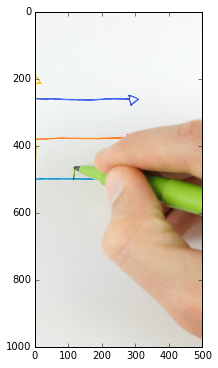

In [16]:
figure(0, (6,6))
imshow(imgRight)

## Now pick the dimensions we want the output image to be, and the bounding values for the output image

In [17]:
outputBounds = 6.5*np.array([-1,1,-1,1])
outputResolution = [1200,1200]

## Create a sampling grid with a complex number for each pixel.

In [18]:
#Create x and y sampling vectors
xInput=np.linspace(inputBounds[0], inputBounds[1], inputResolution[1])
yInput=np.linspace(inputBounds[2], inputBounds[3], inputResolution[0])

#Put sampling vectors on 2d grid:
x,y=np.meshgrid(xInput,yInput)
z=x+1j*y

## We now have a grid of complex input values

In [19]:
z[0:4,0:4]

array([[ 0.00000000-2.j        ,  0.00400802-2.j        ,
         0.00801603-2.j        ,  0.01202405-2.j        ],
       [ 0.00000000-1.995996j  ,  0.00400802-1.995996j  ,
         0.00801603-1.995996j  ,  0.01202405-1.995996j  ],
       [ 0.00000000-1.99199199j,  0.00400802-1.99199199j,
         0.00801603-1.99199199j,  0.01202405-1.99199199j],
       [ 0.00000000-1.98798799j,  0.00400802-1.98798799j,
         0.00801603-1.98798799j,  0.01202405-1.98798799j]])

## The next bit is surprisingly simple

- Numpy is able to handle complex numbers no problem, so performing our mapping is as simple as this.
- We're leaving out the +1 for now to keep things (relatively) simple.

In [20]:
w = z**2

## So we have our mapping, but now we have to actually move our pixels.

Here we'll compute a linear mapping using our input and output bounds to make sure things line up properly.

In [21]:
reSlope = float(outputResolution[1])/(outputBounds[1]-outputBounds[0])
imSlope = float(outputResolution[0])/(outputBounds[3]-outputBounds[2])

reIndex = (w.real*reSlope + outputResolution[1]/2).round().astype('int')
imIndex = (w.imag*imSlope + outputResolution[0]/2).round().astype('int')

## Create an empty matrix to map pixels to, and fill with NaNs

In [22]:
outputImageSize = outputResolution[:]
outputImageSize.append(3)

mappedImage = np.empty(outputImageSize)
mappedImage[:] = NAN

## Nasty Loop Time

- Please don't judge my terribly inefficient code. 
- Iterate through input image, mapping pixels to their proper location on the output
- Theres a couple of feautres here I figured out by trial and error:
    - Since some pixels will map to the same output location (more on this later hopefully), I've added a check for this.
    - I'm much more interested in mapping colored pixels than white pixels, I certainly don't want a white pixel to be mapped on top of a colored one, colored pixels get priority.

In [23]:
whiteThresh = 200
startTime = time.time()

for i in range(inputResolution[0]):
    for j in range(inputResolution[1]):
        #Only map pixels in the output range:
        if reIndex[i, j] > 0 and reIndex[i, j] < outputResolution[1]:
            if imIndex[i,j] > 0 and imIndex[i,j] < outputResolution[0]:
                #Check if that pixel has been filled yet:
                if isnan(mappedImage[imIndex[i,j], reIndex[i,j], 0]):
                    mappedImage[imIndex[i,j], reIndex[i,j], :] =  imgRight[i, j, :]
                #Check if non-white:
                elif imgRight[i, j, 0]< whiteThresh or imgRight[i, j, 1]< whiteThresh or \
                    imgRight[i, j, 2:]< whiteThresh:
                    mappedImage[imIndex[i,j], reIndex[i,j], :] =  imgRight[i, j, :] 
                    
print 'Time Elapsed = ' + str(time.time()-startTime) + 's.'

Time Elapsed = 9.7283718586s.


# And....

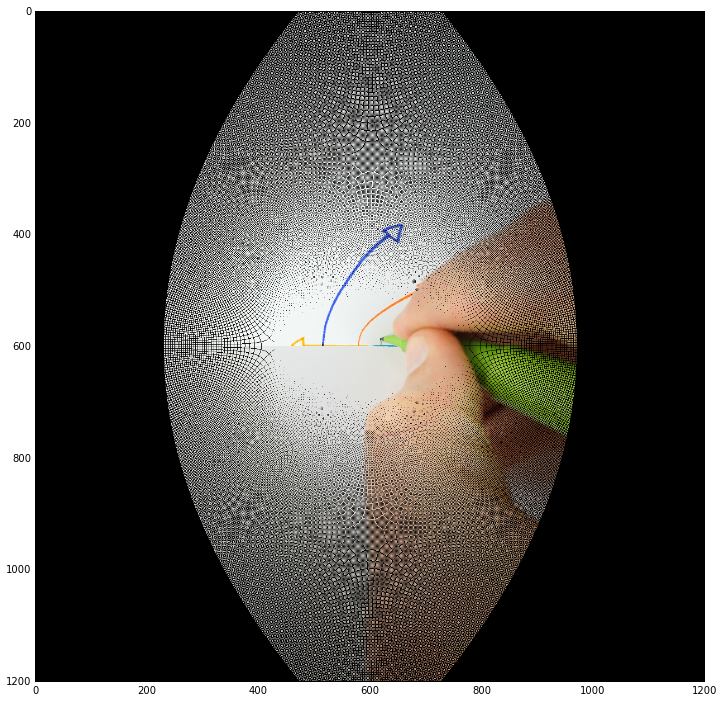

In [24]:
figure(0, (12,12))
mappedImageInt = mappedImage.astype('uint8')
imshow(mappedImageInt)

# Huh?

# Why does it look so weird?

- This actually says ALOT about our function!
- The straight borders of the image have been turned into curvy ones.
- We can really see the pattern of our conformal mapping (straight lines mapped to curved ones, which is pretty cool!)

# However, this isn't really what we had in mind - how do we fix it?
- We'll use a very cool algorithm called inpainting!
- The open computer vision library (opencv) has a nice (but kinda slow...oh well) implementation.
- It uses Navier Stokes equation from fluid mechanics - how cool is that?!?!
- http://docs.opencv.org/2.4/modules/photo/doc/inpainting.html

In [25]:
#Import opencv 2
import cv2

## Create a mask of all the pixels that didn't get filled 
- This mask tells our algorithm where to inpaint

In [26]:
mask = np.zeros((outputResolution[0], outputResolution[1]), dtype='uint8')
mask[isnan(mappedImage[:, :, 0])] = 1

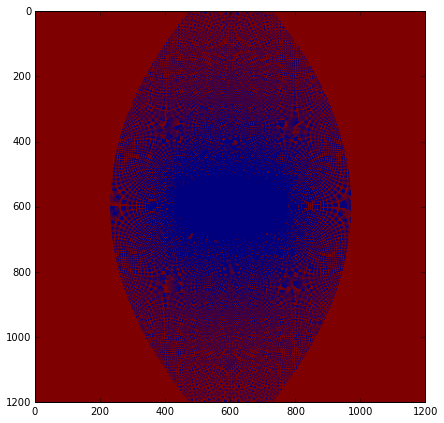

In [27]:
figure(0, (7,7))
imshow(mask)

## Take central crop to cut out curved boundaries


In [29]:
maskCentral = mask.copy()[300:900, 300:900]
mappedImageCentral = mappedImageInt.copy()[300:900, 300:900,:]

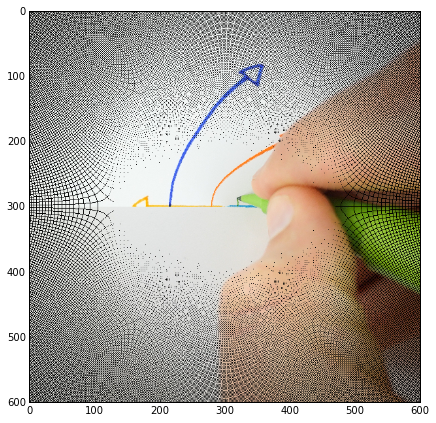

In [30]:
fig = figure(0, (7,7))
imshow(mappedImageCentral)

## And fill in gaps!

In [32]:
startTime = time.time()
finalImage = cv2.inpaint(mappedImageCentral, maskCentral, 3, cv2.INPAINT_NS)
print 'Time Elapsed = ' + str(time.time() - startTime) + 's.'

Time Elapsed = 4.79018998146s.


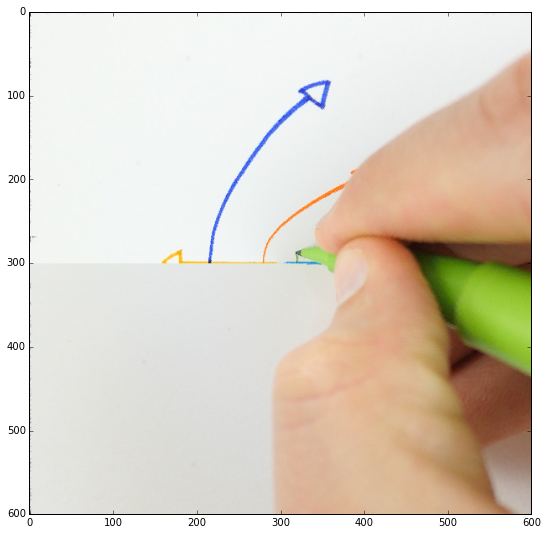

In [33]:
fig = figure(0, (9,9))
imshow(finalImage)

# Done!

- Now all that's left to do is map the other side of the image, and iterate through a bunch of images to make a video.
- In the video, I've used a blend mode in Adobe Premiere to blend the two outputs together into (what appears to be) a single image. 

# And the final result:

In [34]:
from IPython.display import YouTubeVideo
YouTubeVideo('pNp8Qf20-sA', start = 372, width = 800, height = 450)